# HARDWARE

## Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

"""
To change attributes:
1) Change ATTRIBUTE and you're good to go
"""
ATTRIBUTE = 'stg_temp_max'

import os
import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')
snorkel_postgres = os.environ['SNORKELDB'].startswith('postgres')
print snorkel_postgres

True


In [2]:
import os
if snorkel_postgres:
    os.environ['SNORKELDBNAME'] = ATTRIBUTE
    print os.system("dropdb " + os.environ['SNORKELDBNAME'])
    print os.system("createdb " + os.environ['SNORKELDBNAME'])
    print "SNORKELDBNAME = %s" % os.environ['SNORKELDBNAME']
else:
    try:
        os.remove('snorkel.db')
    except:
        pass

from snorkel import SnorkelSession
session = SnorkelSession()

0
0
SNORKELDBNAME = stg_temp_max


## Parsing

In [3]:
import os
if snorkel_postgres:
    from snorkel.async_parser import parse_corpus, HTMLParser, AsyncOmniParser
    print "Starting async parse..."
    
    # PARSE TRAIN
    docs_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/train_small/html/'
    pdf_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/train_small/pdf/'
    doc_parser = HTMLParser()
    context_parser = AsyncOmniParser(blacklist=['style'], flatten=['span','br'], 
                                     tabular=True, lingual=True,
                                     visual=True, pdf_path=pdf_path)
    %time corpus = parse_corpus(session, 'Hardware Train', docs_path,\
                                doc_parser, context_parser,\
                                max_docs=100, parallel=3)
    print "%s contains %d documents" % (corpus, len(corpus))
    
    # PARSE DEV
    docs_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/dev/html/'
    pdf_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/dev/pdf/'
    context_parser = AsyncOmniParser(blacklist=['style'], flatten=['span','br'], 
                                     tabular=True, lingual=True,
                                     visual=True, pdf_path=pdf_path)
    %time corpus = parse_corpus(session, 'Hardware Dev', docs_path,\
                                doc_parser, context_parser,\
                                max_docs=125, parallel=3)
    print "%s contains %d documents" % (corpus, len(corpus))
else:
    from snorkel.parser import CorpusParser, HTMLParser, OmniParser
    from snorkel.utils import get_ORM_instance
    from snorkel.queries import split_corpus

    print "Starting sync parse..."
    # PARSE TRAIN
    docs_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/train_small/html/'
    pdf_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/train_small/pdf/'
    doc_parser = HTMLParser(path=docs_path)
    context_parser = AsyncOmniParser(blacklist=['style'], flatten=['span','br'], 
                                     tabular=True, lingual=True,
                                     visual=True, pdf_path=pdf_path)
    cp = CorpusParser(doc_parser, context_parser, max_docs=100)

    %time corpus = cp.parse_corpus(name='Hardware Train', session=session)
    print "%s contains %d documents" % corpus, len(corpus)

    session.add(corpus)
    session.commit()
    
    # PARSE DEV
    docs_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/dev/html/'
    pdf_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/dev/pdf/'
    doc_parser = HTMLParser(path=docs_path)
    context_parser = AsyncOmniParser(blacklist=['style'], flatten=['span','br'], 
                                 tabular=True, lingual=True,
                                 visual=True, pdf_path=pdf_path)
    cp = CorpusParser(doc_parser, context_parser, max_docs=125)

    %time corpus = cp.parse_corpus(name='Hardware Dev', session=session)
    print "%s contains %d documents" % (corpus, len(corpus))
    session.add(corpus)
    session.commit()

Starting async parse...
[========================================] 100%
CPU times: user 219 ms, sys: 60.8 ms, total: 280 ms
Wall time: 2min 53s
Corpus (Hardware Train) contains 100 documents
[========================================] 100%
CPU times: user 157 ms, sys: 64.9 ms, total: 222 ms
Wall time: 2min 54s
Corpus (Hardware Dev) contains 122 documents


### Save Corpus

In [4]:
# If necessary
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ corpus');

## Extraction

In [5]:
# # If necessary:
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ corpus snorkel.db');

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel import SnorkelSession
# session = SnorkelSession()

In [6]:
from snorkel.models import candidate_subclass

Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

### Define Matchers

In [7]:
from hardware_matchers import get_matcher

part_matcher = get_matcher('part')
attr_matcher = get_matcher(ATTRIBUTE)

### Define ContextSpaces

In [8]:
from hardware_utils import OmniNgramsPart
from hardware_spaces import get_space
    
part_ngrams = OmniNgramsPart(parts_by_doc=None, n_max=3)
attr_ngrams = get_space(ATTRIBUTE)

### Define Candidate Throttler

In [9]:
from hardware_utils import get_part_throttler

part_throttler = get_part_throttler()

### Run CandidateExtractor

In [10]:
from snorkel.models import Corpus
from snorkel.candidates import CandidateExtractor
from snorkel.utils import get_ORM_instance
ce = CandidateExtractor(Part_Attr, 
                        [part_ngrams, attr_ngrams], 
                        [part_matcher, attr_matcher], 
                        throttler=part_throttler)

for corpus_name in ['Hardware Train', 'Hardware Dev']:
    corpus = get_ORM_instance(Corpus, session, corpus_name)
    print "Extracting Candidates from %s" % corpus
    %time candidates = ce.extract(\
        corpus.documents, corpus_name + ' Candidates', session)
    session.add(candidates)
    print "%s contains %d Candidates" % (candidates, len(candidates))
session.commit()

Extracting Candidates from Corpus (Hardware Train)
[========================================] 100%
CPU times: user 6min 20s, sys: 3.14 s, total: 6min 23s
Wall time: 7min 42s
Candidate Set (Hardware Train Candidates) contains 11181 Candidates
Extracting Candidates from Corpus (Hardware Dev)
[========================================] 100%
CPU times: user 30min 11s, sys: 20 s, total: 30min 31s
Wall time: 35min 46s
Candidate Set (Hardware Dev Candidates) contains 41761 Candidates


### Second Pass

In [11]:
from hardware_utils import get_gold_parts_by_doc, get_manual_parts_by_doc
from snorkel.utils import get_ORM_instance
from snorkel.models import Corpus

corpus = get_ORM_instance(Corpus, session, 'Hardware Dev')

# parts_by_doc = get_gold_parts_by_doc()
parts_by_doc = get_manual_parts_by_doc(corpus.documents)
# parts_by_doc = None

Finding part numbers...
[========================================] 100%
Appending suffixes...
[========================================] 100%


In [12]:
import cPickle as pickle
pickle_file = os.environ['SNORKELHOME'] + '/tutorials/tables/sandbox/parts_by_doc.pkl'

with open(pickle_file, 'w') as f:
    pickle.dump(parts_by_doc, f)

In [ ]:
# import cPickle as pickle
# pickle_file = os.environ['SNORKELHOME'] + '/tutorials/tables/sandbox/parts_by_doc.pkl'
# with open(pickle_file, 'r') as f:
#     parts_by_doc = pickle.load(f)

### Assess Recall

In [13]:
from snorkel.models import Corpus, CandidateSet
from hardware_utils import entity_level_total_recall

corpus = get_ORM_instance(Corpus, session, 'Hardware Dev')
candidates = get_ORM_instance(CandidateSet, session, 'Hardware Dev Candidates')
gold_file = os.environ['SNORKELHOME'] + \
    '/tutorials/tables/data/hardware/dev/hardware_dev_gold.csv'
(tp, fp, fn) = entity_level_total_recall(candidates, gold_file, ATTRIBUTE, corpus=corpus, 
                                         relation=False, parts_by_doc=parts_by_doc)

Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision 0.804
Corpus Recall    0.92
Corpus F1        0.858
----------------------------------------
TP: 818 | FP: 199 | FN: 71



In [14]:
from pprint import pprint
pprint(fp)

[(u'BC337', u'BC33716'),
 (u'BC337', u'BC33725'),
 (u'BC337', u'BC33740'),
 (u'BC337', u'BC33740BU'),
 (u'BC337', u'BC338-16'),
 (u'BC337', u'BC338-40'),
 (u'BC337', u'BC33825'),
 (u'BC337-D', u'BC337-XX'),
 (u'BC546', u'BC548A'),
 (u'BC546', u'BC549A'),
 (u'BC546', u'BC550A'),
 (u'BC546', u'BC550B'),
 (u'BC546-BC548C(TO-92)', u'BC546-BC548C'),
 (u'BC546_DIOTEC', u'BC546C'),
 (u'BC546_DIOTEC', u'BC549A'),
 (u'BC547', u'BC548A'),
 (u'BC547', u'BC548BU'),
 (u'BC547', u'BC549A'),
 (u'BC547', u'BC550A'),
 (u'BC547', u'BC550B'),
 (u'BC818-40LT1-D', u'BC818-40LT1'),
 (u'CENTRALSEMICONDUCTORCORP_2N4013', u'2N3576'),
 (u'CENTRALSEMICONDUCTORCORP_2N4013', u'2N3672'),
 (u'CENTRALSEMICONDUCTORCORP_2N4013', u'2N3700'),
 (u'CENTRALSEMICONDUCTORCORP_2N4013', u'2N3701'),
 (u'CENTRALSEMICONDUCTORCORP_2N4013', u'2N3798A'),
 (u'CENTRALSEMICONDUCTORCORP_2N4013', u'2N3799A'),
 (u'CENTRALSEMICONDUCTORCORP_2N4013', u'2N3829'),
 (u'CENTRALSEMICONDUCTORCORP_2N4013', u'2N3946'),
 (u'CENTRALSEMICONDUCTORCORP_2N

In [15]:
pprint(fn)

[('CENTRALSEMICONDUCTORCORP_CENU45', 'CEN-U45'),
 ('CENTRALSEMICONDUCTORCORP_CMPT5401ETR', 'CMPT5401E'),
 ('CENTRALSEMICONDUCTORCORP_CXT4033TR', 'CXT4033'),
 ('DIODESINCORPORATED_2DD26527', '2DD2652'),
 ('DIODESINCORPORATED_2DD26527', '2DD2652-7'),
 ('DIODESINCORPORATED_FCX491ATA', 'FCX491A'),
 ('DIODESINCORPORATED_ZXT690BKTC', 'ZXT690BKQTC'),
 ('DIODESINCORPORATED_ZXT690BKTC', 'ZXT690BKTC'),
 ('DISES00490-1', 'BC846AW'),
 ('DISES00490-1', 'BC846BW'),
 ('DISES00490-1', 'BC847AW'),
 ('DISES00490-1', 'BC847BW'),
 ('DISES00490-1', 'BC847CW'),
 ('DISES00490-1', 'BC848AW'),
 ('DISES00490-1', 'BC848BW'),
 ('DISES00490-1', 'BC848CW'),
 ('DISES00490-1', 'BC849BW'),
 ('DISES00490-1', 'BC849CW'),
 ('FAIRCHILDSEMICONDUCTOR_KSC2310YTA', 'KSC2310'),
 ('FAIRCHILDSEMICONDUCTOR_KSC2310YTA', 'KSC2310O'),
 ('FAIRCHILDSEMICONDUCTOR_KSC2310YTA', 'KSC2310R'),
 ('FAIRCHILDSEMICONDUCTOR_KSC2310YTA', 'KSC2310Y'),
 ('LITES00689-1', 'BC337-25'),
 ('MICROCOMMERCIALCO_2N3904AP', '2N3904-AP'),
 ('MICROCOMMERCIALCO

In [16]:
# If necessary
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ candidates');

## Gold Labels

In [17]:
# If necessary
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ candidates snorkel.db');

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel import SnorkelSession
# session = SnorkelSession()

# from snorkel.models import candidate_subclass
# Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

In [18]:
import os
from snorkel.models import CandidateSet
from hardware_utils import load_hardware_labels

gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/dev/hardware_dev_gold.csv'
for set_name in ['Dev']:
    candidate_set_name = 'Hardware %s Candidates' % set_name
    candidates = session.query(CandidateSet).filter(
        CandidateSet.name == candidate_set_name).one()
    label_set_name = 'Hardware %s Candidates -- Gold' % set_name
    annotation_key_name = 'Hardware %s Labels -- Gold' % set_name
    %time gold_candidates, annotation_key = load_hardware_labels(session,\
                           label_set_name, \
                           annotation_key_name, \
                           candidates, \
                           gold_file, \
                           ATTRIBUTE)
    candidates_gold = session.query(CandidateSet).filter(
        CandidateSet.name == candidate_set_name + ' -- Gold').one()
    print "%d/%d Candidates in %s have positive Labels" % (
        len(candidates_gold), len(candidates), candidates)

Loading 41761 candidate labels
[========================================] 100%
CPU times: user 1min 10s, sys: 3.79 s, total: 1min 14s
Wall time: 1min 31s
16507/41761 Candidates in Candidate Set (Hardware Dev Candidates) have positive Labels


In [19]:
# If necessary
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ labels');

## Features

In [20]:
# # If necessary:
# import os
# # os.remove('snorkel.db');
# os.system('cp snorkel.db\ labels snorkel.db');

# from snorkel import SnorkelSession
# session = SnorkelSession()

# from snorkel.models import candidate_subclass
# Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

### Extract Features

In [21]:
from snorkel.models import CandidateSet
from snorkel.utils import get_ORM_instance

train = get_ORM_instance(CandidateSet, session, 'Hardware Train Candidates')
dev   = get_ORM_instance(CandidateSet, session, 'Hardware Dev Candidates')

if snorkel_postgres:
    from snorkel.async_annotations import annotate
    print "Starting async featurization..."
    %time F_train = annotate(train, parallel=3)
    %time F_dev   = annotate(dev,   parallel=3, keyset = 'Hardware Train Candidates')

else:
    from snorkel.models import CandidateSet
    from snorkel.fast_annotations import FeatureManager
    from snorkel.utils import get_ORM_instance

    print "Starting sync featurization..."
    feature_manager = FeatureManager()
    %time F_train = feature_manager.create(session, train, 'Train Features')
    %time F_dev = feature_manager.update(session, dev, 'Train Features', expand_key_set=False)

CPU times: user 19 s, sys: 451 ms, total: 19.5 s
Wall time: 4min 7s
[========================================] 100%
CPU times: user 54.1 s, sys: 1.51 s, total: 55.6 s
Wall time: 9min 24s
[========================================] 100%


In [22]:
# If necessary:
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ featurized');

## LFs

In [23]:
# If necessary
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ featurized snorkel.db');

# from snorkel import SnorkelSession
# session = SnorkelSession()

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel.models import candidate_subclass
# Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

# from snorkel.models import CandidateSet
# train = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Train Candidates').one()
# dev = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Dev Candidates').one()

# from snorkel.annotations import FeatureManager, LabelManager
# feature_manager = FeatureManager()
# %time F_train = feature_manager.load(session, train, 'Train Features')
# %time F_dev = feature_manager.load(session, dev, 'Train Features')

### Define LFs

In [31]:
from hardware_lfs import get_lfs

LFs = get_lfs(ATTRIBUTE)

### Apply LFs

In [32]:
if snorkel_postgres:
    from snorkel.async_annotations import annotate
    %time L_train = annotate(train, parallel=3, lfs=LFs)
else:
    from snorkel.fast_annotations import LabelManager
    label_manager = LabelManager()
    %time L_train = label_manager.create(session, train, 'LF Labels', f=LFs)
L_train

CPU times: user 2.39 s, sys: 103 ms, total: 2.5 s
Wall time: 8min 15s
[========================================] 100%


<11181x20 sparse matrix of type '<type 'numpy.float32'>'
	with 38660 stored elements in Compressed Sparse Row format>

### Assess LF accuracy

In [33]:
%time L_train.lf_stats()

CPU times: user 4.82 ms, sys: 2.45 ms, total: 7.27 ms
Wall time: 6.04 ms


,conflicts,coverage,j,overlaps
LF_collector_aligned,0.000000,0.046955,0,0.046955
LF_too_many_numbers_row,0.007423,0.635364,1,0.635364
LF_current_aligned,0.000537,0.096682,2,0.096682
LF_complement_left_row,0.000000,0.000000,3,0.000000
LF_replacement_table,0.001073,0.005366,4,0.005366
LF_operating_row,0.093462,0.093462,5,0.093462
LF_typ_row,0.000000,0.001073,6,0.001073
LF_not_temp_relevant,0.000179,0.873893,7,0.873893
LF_many_p_siblings,0.000000,0.000000,8,0.000000
LF_temperature_row,0.115911,0.115911,9,0.115911


In [34]:
# If necessary
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ features');

## Learn and Evaluate

In [35]:
# If necessary:
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ features snorkel.db');

# from snorkel import SnorkelSession
# session = SnorkelSession()

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel.models import candidate_subclass
# Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

# from snorkel.models import CandidateSet
# train = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Training Candidates').one()
# dev = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Development Candidates').one()

# from snorkel.annotations import FeatureManager, LabelManager
# feature_manager = FeatureManager()
# %time F_train = feature_manager.load(session, train, 'Train Features')
# %time F_dev = feature_manager.load(session, dev, 'Train Features')

# label_manager = LabelManager()
# %time L_train = label_manager.load(session, train, 'LF Labels')

In [56]:
from snorkel.learning import NaiveBayes

gen_model = NaiveBayes()
gen_model.train(L_train, n_iter=25000, rate=1e-2, mu=1e-4)
train_marginals = gen_model.marginals(L_train)

Training marginals (!= 0.5):	11181
Features:			20
Begin training for rate=0.01, mu=0.0001
	Learning epoch = 0	Gradient mag. = 0.625834
	Learning epoch = 250	Gradient mag. = 0.865273
	Learning epoch = 500	Gradient mag. = 0.923654
	Learning epoch = 750	Gradient mag. = 0.944192
	Learning epoch = 1000	Gradient mag. = 0.736334
	Learning epoch = 1250	Gradient mag. = 0.532903
	Learning epoch = 1500	Gradient mag. = 0.443203
	Learning epoch = 1750	Gradient mag. = 0.401464
	Learning epoch = 2000	Gradient mag. = 0.378372
	Learning epoch = 2250	Gradient mag. = 0.362808
	Learning epoch = 2500	Gradient mag. = 0.350852
	Learning epoch = 2750	Gradient mag. = 0.341104
	Learning epoch = 3000	Gradient mag. = 0.332759
	Learning epoch = 3250	Gradient mag. = 0.320491
	Learning epoch = 3500	Gradient mag. = 0.309520
	Learning epoch = 3750	Gradient mag. = 0.299772
	Learning epoch = 4000	Gradient mag. = 0.291189
	Learning epoch = 4250	Gradient mag. = 0.283716
	Learning epoch = 4500	Gradient mag. = 0.277304
	Lea

In [57]:
from snorkel.learning import LogReg

disc_model = LogReg()
disc_model.train(F_train, train_marginals, n_iter=2000, rate=1e-4)

Training marginals (!= 0.5):	11181
Features:			5642
Using gradient descent...
	Learning epoch = 0	Step size = 0.0001
	Loss = 7750.078626	Gradient magnitude = 24696.051319
	Learning epoch = 100	Step size = 9.04792147114e-05
	Loss = 80.889784	Gradient magnitude = 83.781715
	Learning epoch = 200	Step size = 8.18648829479e-05
	Loss = 46.757714	Gradient magnitude = 47.450432
	Learning epoch = 300	Step size = 7.40707032156e-05
	Loss = 34.153930	Gradient magnitude = 34.325827
	Learning epoch = 400	Step size = 6.70185906007e-05
	Loss = 27.550457	Gradient magnitude = 27.554439
	Learning epoch = 500	Step size = 6.06378944861e-05
	Loss = 23.487543	Gradient magnitude = 23.420731
	Learning epoch = 600	Step size = 5.48646907485e-05
	Loss = 20.744091	Gradient magnitude = 20.641385
	Learning epoch = 700	Step size = 4.96411413431e-05
	Loss = 18.775433	Gradient magnitude = 18.651987
	Learning epoch = 800	Step size = 4.4914914861e-05
	Loss = 17.301047	Gradient magnitude = 17.164461
	Learning epoch = 900	

In [58]:
dev_gold = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Dev Candidates -- Gold').one()

In [39]:
# if snorkel_postgres:
#     L_dev = annotate(dev, lfs=LFs)
# else:
from snorkel.annotations import LabelManager
label_manager = LabelManager()
L_dev = label_manager.load(session, dev, 'Hardware Dev Labels -- Gold')
L_dev.shape

(41761, 1)

Calibration plot:


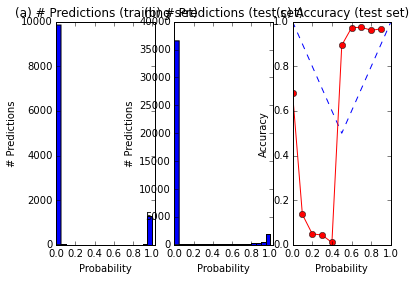

Recall-corrected Noise-aware Model
Pos. class accuracy: 0.21833161689
Neg. class accuracy: 0.994614714501
Corpus Precision 0.964
Corpus Recall    0.218
Corpus F1        0.356
----------------------------------------
TP: 3604 | FP: 136 | TN: 25118 | FN: 12903

Recall-corrected Noise-aware Model
Pos. class accuracy: 0.109165808445
Neg. class accuracy: 0.994614714501
Corpus Precision 0.964
Corpus Recall    0.109
Corpus F1        0.196
----------------------------------------
TP: 3604 | FP: 136 | TN: 25118 | FN: 29410



In [59]:
tp, fp, tn, fn = disc_model.score(F_dev, L_dev, dev_gold)

In [60]:
from snorkel.models import Corpus
from hardware_utils import entity_level_f1
import os

gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/dev/hardware_dev_gold.csv'
corpus = session.query(Corpus).filter(Corpus.name == 'Hardware Dev').one()
(TP, FP, FN) = entity_level_f1(tp, fp, tn, fn, gold_file, corpus, ATTRIBUTE)

Scoring on Entity-Level Gold Data
Corpus Precision 0.91
Corpus Recall    0.611
Corpus F1        0.731
----------------------------------------
TP: 543 | FP: 54 | FN: 346



In [42]:
from pprint import pprint
pprint(FP)

[(u'BC337', u'BC33716', u'150'),
 (u'BC337', u'BC33725', u'150'),
 (u'BC337', u'BC33740', u'150'),
 (u'BC337', u'BC33740BU', u'150'),
 (u'BC337', u'BC33825', u'150'),
 (u'BC546-BC548C(TO-92)', u'BC546-BC548C', u'150'),
 (u'BC547', u'BC548BU', u'150'),
 (u'BC818-40LT1-D', u'BC818-40LT1', u'150'),
 (u'CSEMS05382-1', u'BC546-48ABC', u'150'),
 (u'DIODESINCORPORATED_FCX491ATA', u'AP02001', u'150'),
 (u'DIODESINCORPORATED_FCX491ATA', u'AP02002', u'150'),
 (u'DIODESINCORPORATED_FZT651TC', u'AP02001', u'150'),
 (u'DIODESINCORPORATED_FZT651TC', u'AP02002', u'150'),
 (u'DIODESINCORPORATED_ZXT690BKTC', u'AP02001', u'150'),
 (u'DIODESINCORPORATED_ZXT690BKTC', u'AP02002', u'150'),
 (u'DIODESINCORPORATED_ZXT690BKTC', u'ZXT690B', u'150'),
 (u'DIODS13249-1', u'BC808', u'150'),
 (u'DIODS13249-1', u'BC81840', u'150'),
 (u'DISES00189-1', u'BC546XBK', u'150'),
 (u'DISES00189-1', u'BC547XBK', u'150'),
 (u'DISES00189-1', u'BC548XBK', u'150'),
 (u'DISES00189-1', u'BC549XBK', u'150'),
 (u'INFINEON-BC817KSERIE

In [43]:
from pprint import pprint
pprint(FN)

[('112823', 'BC546BG', '150'),
 ('112823', 'BC546BRL1G', '150'),
 ('112823', 'BC546BZL1G', '150'),
 ('112823', 'BC547ARLG', '150'),
 ('112823', 'BC547AZL1G', '150'),
 ('112823', 'BC547BG', '150'),
 ('112823', 'BC547BRL1G', '150'),
 ('112823', 'BC547BZL1G', '150'),
 ('112823', 'BC547CG', '150'),
 ('112823', 'BC547CZL1G', '150'),
 ('112823', 'BC548BG', '150'),
 ('112823', 'BC548BRL1G', '150'),
 ('112823', 'BC548BZL1G', '150'),
 ('112823', 'BC548CG', '150'),
 ('112823', 'BC548CZL1G', '150'),
 ('BC337', 'BC337-16', '150'),
 ('BC337', 'BC337-25', '150'),
 ('BC337', 'BC337-40', '150'),
 ('BC337', 'BC338-25', '150'),
 ('BC546-D', 'BC546BG', '150'),
 ('BC546-D', 'BC546BRL1G', '150'),
 ('BC546-D', 'BC546BZL1G', '150'),
 ('BC546-D', 'BC547ARLG', '150'),
 ('BC546-D', 'BC547AZL1G', '150'),
 ('BC546-D', 'BC547BG', '150'),
 ('BC546-D', 'BC547BRL1G', '150'),
 ('BC546-D', 'BC547BZL1G', '150'),
 ('BC546-D', 'BC547CG', '150'),
 ('BC546-D', 'BC547CZL1G', '150'),
 ('BC546-D', 'BC548BG', '150'),
 ('BC546-D

In [48]:
from pprint import pprint
pprint([(unicode(x[0]), x[1]) for x in disc_model.get_feature_weights(F_dev)])

[(u'CORE_e2_LENGTH_1', -1.4294136724273905),
 (u'CORE_e2_SPAN_TYPE_[IMPLICIT]', -1.4294136724273905),
 (u'TAB_e2_ROW_WORDS_[tstg]', 0.8845158986135604),
 (u'CORE_e1_LENGTH_1', -0.8288016004018507),
 (u'TAB_e2_CELL_WORDS_[to]', 0.8224021722104976),
 (u'TAB_e2_ROW_WORDS_[to]', 0.7896291386182321),
 (u'CORE_e1_SPAN_TYPE_[IMPLICIT]', -0.7341441562328249),
 (u'VIZ_e1_PAGE_[1]', -0.7294139931883116),
 (u'CORE_e1_SPAN_TYPE_[EXPLICIT]', -0.6932725143626278),
 (u'TAB_e2_ROW_WORDS_[temperature]', 0.6900863959256976),
 (u'TAB_e2_ROW_WORDS_[storage]', 0.58075857881812),
 (u'TAB_e2_ROW_WORDS_[c]', 0.569799256792616),
 (u'VIZ_e2_PAGE_[3]', -0.5383559363572836),
 (u'TAB_e2_ROW_HEAD_WORDS_[tstg]', 0.5127563881470183),
 (u'TAB_e2_CELL_WORDS_[-55]', 0.4893277992225905),
 (u'TAB_e2_ROW_WORDS_[-55]', 0.4893277992225905),
 (u'TAB_e2_CELL_WORDS_[-55 to]', 0.48424475963681296),
 (u'TAB_e2_ROW_WORDS_[-55 to]', 0.48424475963681296),
 (u'TAB_e2_COL_WORDS_[to]', 0.447077573840977),
 (u'TAB_e2_ROW_WORDS_[junction

In [ ]:
from hardware_utils import entity_to_candidates, get_part_throttler

entity = FP[0]
print entity
print

matches = entity_to_candidates(entity, fp)
print "# Matches: %d" % len(matches)
print

candidate = matches[0]
print candidate
print

throttler = get_part_throttler()
print throttler(candidate)
# print disc_model.get_candidate_score(candidate, F_dev)
# print
# pprint(disc_model.get_candidate_feature_weights(candidate, F_dev))

In [ ]:
# from hardware_utils import part_error_analysis
# part_error_analysis(candidate)

In [ ]:
# If necessary:
# import os
# os.system('cp snorkel.db snorkel.db\ final');